# Download and import essentials
Furthermore, before doing anything, we should check if GPUs are already enabled and ready to used

In [ ]:
!pip install torchaudio==0.9.1
!git clone https://github.com/thanhtvt/SpecAugment.git

fatal: destination path 'SpecAugment' already exists and is not an empty directory.


In [ ]:
# Import google drive to save model
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import torchaudio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
from tqdm.notebook import tqdm

Check CUDA GPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Loading datasets

In [ ]:
from torchaudio.datasets import SPEECHCOMMANDS
import os

class Datasets(SPEECHCOMMANDS):
  def __init__(self, subset: str=None):
    super().__init__("./", download=True)

    def load_data(filename):
      filepath = os.path.join(self._path, filename)
      fileobj = open(filepath)
      return [os.path.join(self._path, line.strip()) for line in fileobj]

    if subset == "validation":
      self._walker = load_data("validation_list.txt")
    elif subset == "testing":
      self._walker = load_data("testing_list.txt")
    elif subset == "training":
      excludes = load_data("validation_list.txt") + load_data("testing_list.txt")
      excludes = set(excludes)
      self._walker = [w for w in self._walker if w not in excludes]
    else:
      print("Invalid option")

train_set = Datasets("training")
test_set = Datasets("testing")
val_set = Datasets("validation")

__ getitem __ returns:
- waveform: Tuple
- sample_rate: int
- label: str 
- speaker_id: int
- utterance_number: int

# Exploring data

Sample rate: 16000
Shape of waveform: torch.Size([1, 16000])


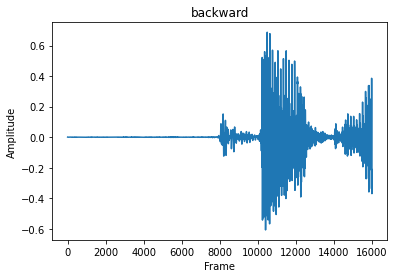

In [ ]:
# Take a peek at data
waveform, sample_rate, label, spk_id, utt_num = train_set.__getitem__(120)
print("Sample rate:", sample_rate)
print("Shape of waveform:", waveform.shape)

# Plot waveform
fig = plt.figure()
plt.title(label)
plt.xlabel("Frame")
plt.ylabel("Amplitude")
plt.plot(waveform.t())

Find labels 

In [ ]:
labels = sorted(list(set(data[2] for data in train_set)))
print("Number of labels:", len(labels))
print(labels)

Number of labels: 35
['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


Hear some files

In [ ]:
id = 5123
waveform, sample_rate, label, *_ = train_set[id]
print(label)
ipd.Audio(waveform.numpy(), rate=sample_rate)

bird


## Apply some advance techniques to visualize data 
Credit to [davids1992](https://www.kaggle.com/davids1992/speech-representation-and-data-exploration)

Define a function that calculates spectrogram  
The reason for doing that is that it will make our plot much more clear. Moreover, it is strictly connected to the way people hear

### Wave and Spectrogram

In [ ]:
from scipy import signal
from scipy.fftpack import fft
import librosa
import librosa.display as display

def log_spectrogram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
  """
  (I think) this is similar to the framing step in Mel's calculation
  More infomation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html#scipy.signal.spectrogram
  """
  # second per segment
  nperseg = int(round(window_size * sample_rate / 1e3))
  # second overlapping
  noverlap = int(round(step_size * sample_rate / 1e3))

  freqs, times, spec = signal.spectrogram(audio, fs=sample_rate,
                                          window='hann',
                                          nperseg=nperseg,
                                          noverlap=noverlap,
                                          detrend=False)
  
  return freqs, times, np.log(spec.T.astype(np.float32) + eps)

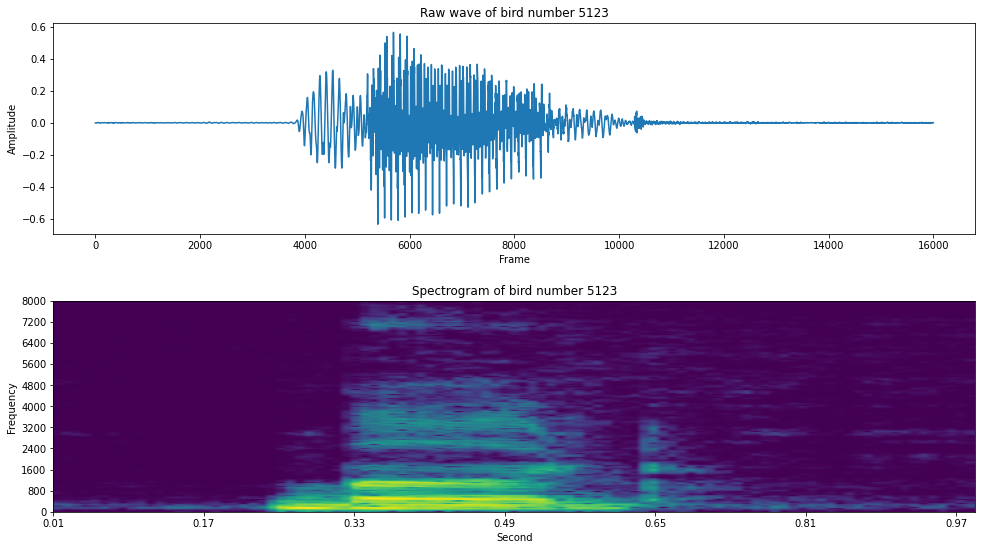

In [ ]:
freqs, times, log_spec = log_spectrogram(waveform.numpy(), sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = plt.subplot(211)
ax1.set_title("Raw wave of {} number {}".format(label, id))
ax1.set_xlabel("Frame")
ax1.set_ylabel("Amplitude")
ax1.plot(waveform.t().numpy())

ax2 = plt.subplot(212)
ax2.imshow(log_spec.T.squeeze(), aspect="auto", origin="lower",
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_title("Spectrogram of {} number {}".format(label, id))
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_xlabel("Second")
ax2.set_ylabel("Frequency")

fig.tight_layout(pad=2.0)

Let's add some white noise to generalize all the cases (I will only add noise for visualization purposes. During training, I will not add any because of the property of this dataset)  
First thing to do is create noise (I only get variance as 0.05 because the amplitude of sound is way too small)  
And the reason why I create noise with normal distribution is explained and experimented in [this paper](https://www.cs.cmu.edu/~robust/Papers/KimSternIS08.pdf)

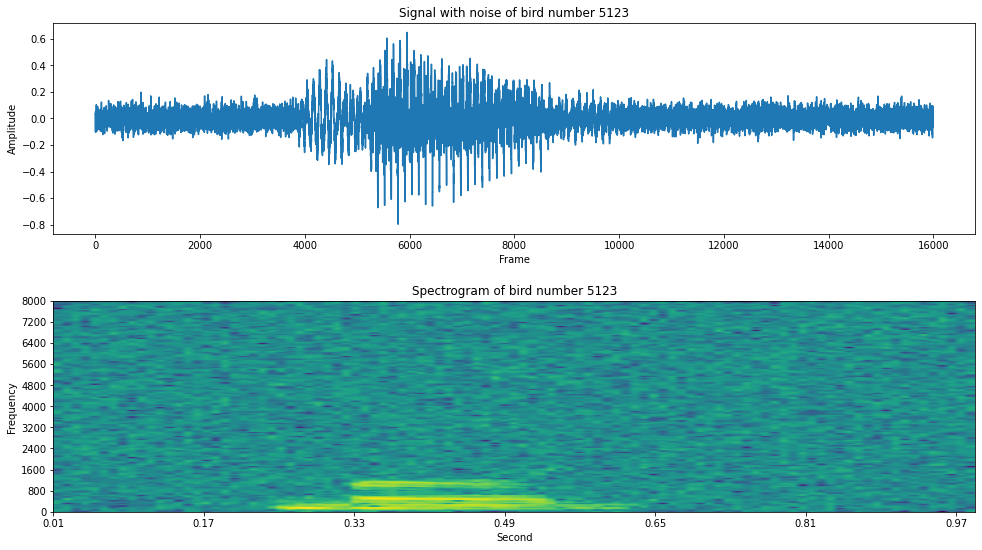

In [ ]:
# Create noise
noise = np.random.normal(0, 0.05, sample_rate)
signal_with_noise = waveform + noise

# Plot signal with noise
freqs, times, log_spec_with_noise = log_spectrogram(signal_with_noise.numpy(), sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = plt.subplot(211)
ax1.set_title("Signal with noise of {} number {}".format(label, id))
ax1.set_xlabel("Frame")
ax1.set_ylabel("Amplitude")
ax1.plot(signal_with_noise.t().numpy())

ax2 = plt.subplot(212)
ax2.imshow(log_spec_with_noise.T.squeeze(), aspect="auto", origin="lower",
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_title("Spectrogram of {} number {}".format(label, id))
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_xlabel("Second")
ax2.set_ylabel("Frequency")

fig.tight_layout(pad=2.0)

Try to hear that

In [ ]:
ipd.Audio(signal_with_noise.numpy(), rate=sample_rate)

If we use spectrogram as an input features for NN, we have to normalize features for all of the dataset. Below is the example for just 1

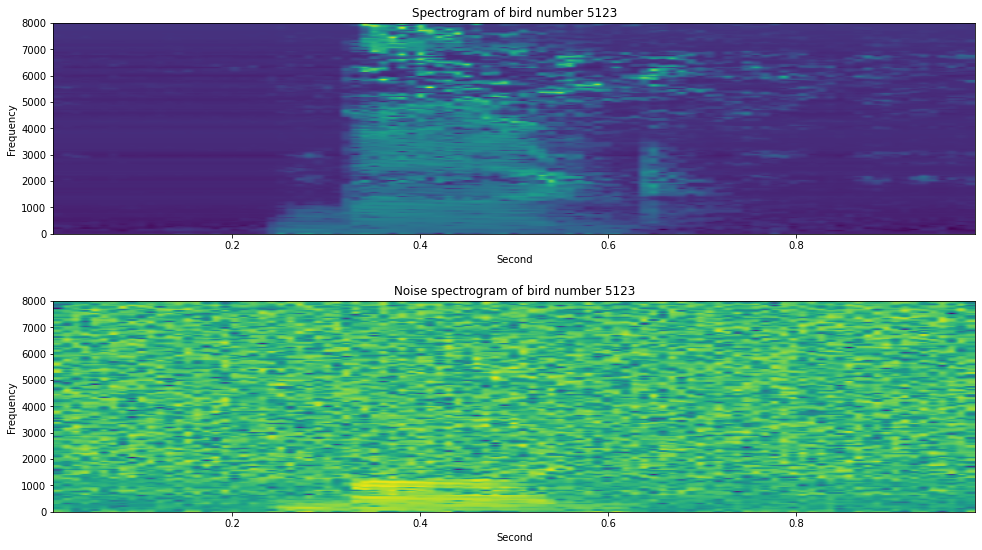

In [ ]:
fig = plt.figure(figsize=(14, 8))

# Clean sound
ax1 = plt.subplot(211)
mean = np.mean(log_spec, axis=0)
std = np.std(log_spec, axis=0)
log_spec_norm = (log_spec - mean) / std

ax1.imshow(log_spec_norm.T.squeeze(), aspect="auto", origin="lower",
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax1.set_title("Spectrogram of {} number {}".format(label, id))
ax1.set_xlabel("Second")
ax1.set_ylabel("Frequency")

# With noise 
ax2 = plt.subplot(212)
mean = np.mean(log_spec_with_noise, axis=0)
std = np.std(log_spec_with_noise, axis=0)
log_spec_with_noise_norm = (log_spec_with_noise - mean) / std

ax2.imshow(log_spec_with_noise_norm.T.squeeze(), aspect="auto", origin="lower",
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_title("Noise spectrogram of {} number {}".format(label, id))
ax2.set_xlabel("Second")
ax2.set_ylabel("Frequency")

fig.tight_layout(pad=2.0)

### MFCC
Calculate MFCC by using *librosa* python package  
Find more information on this [notebook](https://github.com/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb)

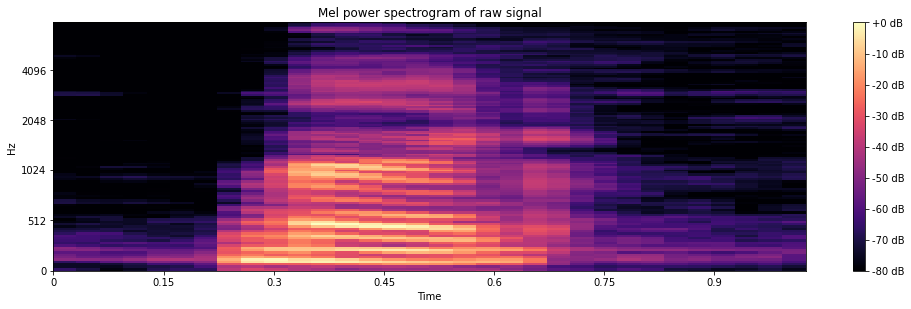

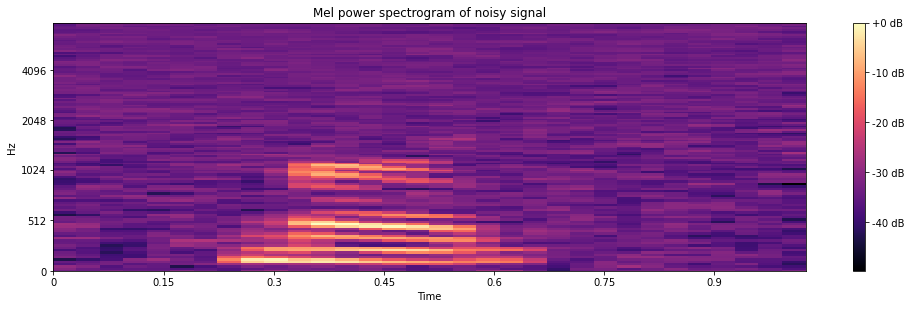

In [ ]:
# Calculate MFCC
S = librosa.feature.melspectrogram(waveform.numpy().squeeze(), sr=sample_rate, n_mels=128)
# Convert to log scale (dB)
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(14, 8))
plt.subplot(211)
display.specshow(log_S, sr=sample_rate, x_axis="time", y_axis="mel")
plt.title("Mel power spectrogram of raw signal")
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

# Calculate MFCC for noisy signal
S_noise = librosa.feature.melspectrogram(signal_with_noise.numpy().squeeze(), sr=sample_rate, n_mels=128)
# Convert to log scale (dB)
log_S_noise = librosa.power_to_db(S_noise, ref=np.max)

plt.figure(figsize=(14, 8))
plt.subplot(212)
display.specshow(log_S_noise, sr=sample_rate, x_axis="time", y_axis="mel")
plt.title("Mel power spectrogram of noisy signal")
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

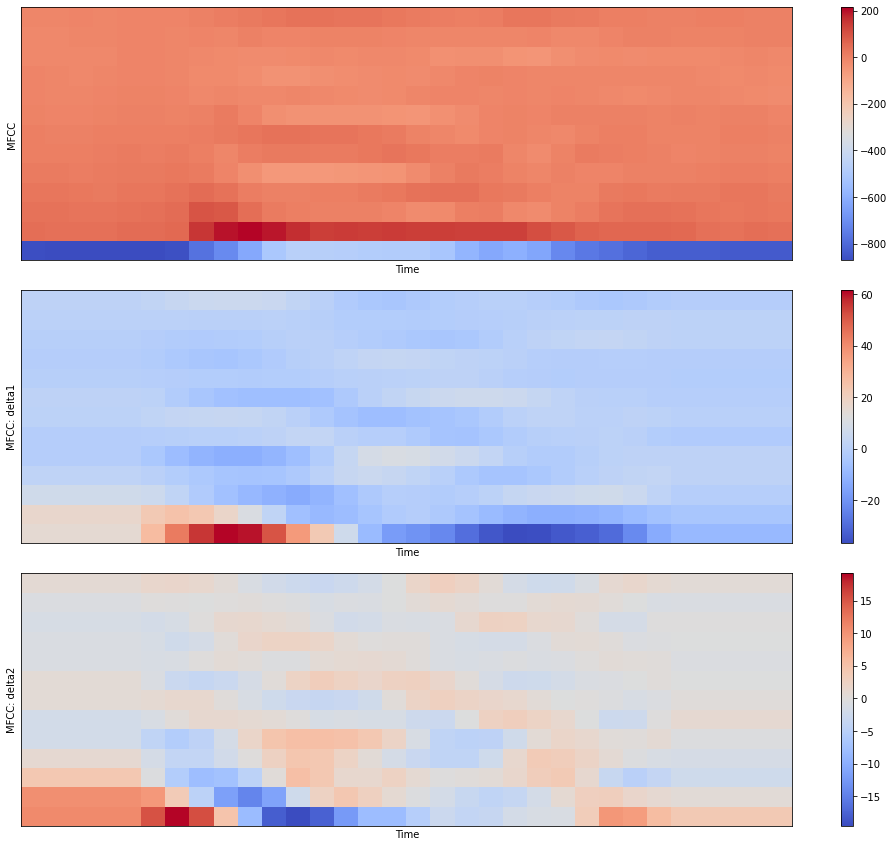

In [ ]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Pad on the first and second delta
delta_mfcc = librosa.feature.delta(mfcc, order=1)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

# Show each on its own subplot
plt.figure(figsize=(14, 12))

plt.subplot(311)
display.specshow(mfcc)
plt.ylabel('MFCC')
plt.xlabel('Time')
plt.colorbar()

plt.subplot(312)
display.specshow(delta_mfcc)
plt.ylabel('MFCC: delta1')
plt.xlabel('Time')
plt.colorbar()

plt.subplot(313)
display.specshow(delta2_mfcc)
plt.ylabel('MFCC: delta2')
plt.xlabel('Time')
plt.colorbar()

plt.tight_layout(pad=1.5)

In classical (still SOTA systems), MFCC or similar features are taken as the input to the system instead of spectrograms.  
However, in end-to-end systems (often NN-based), the most common input features are probably raw spectrograms, or mel power spectrogram.  
For example, MFCC decorrelates features, but NNs deal with correlated features well.

### SpecAugment  
This is the audio augmentation approach introduced by Google AI. Instead of augmenting the input audio waveform, SpecAugment applies an augmentation policy directly to the audio spectrogram. Moreover, it can be run online during training without significantly impacting training speed.  
  
Follow this [link](https://arxiv.org/abs/1904.08779) to have more in-depth information about this technique. 

/content/SpecAugment
/content


/content/SpecAugment/SpecAugment/sparse_image_warp_pytorch.py:182: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  X, LU = torch.solve(rhs, lhs)
/content/SpecAugment/SpecAugment/sparse_image_warp_pytorch.py:377: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(queries - floor, dtype=grid_type)


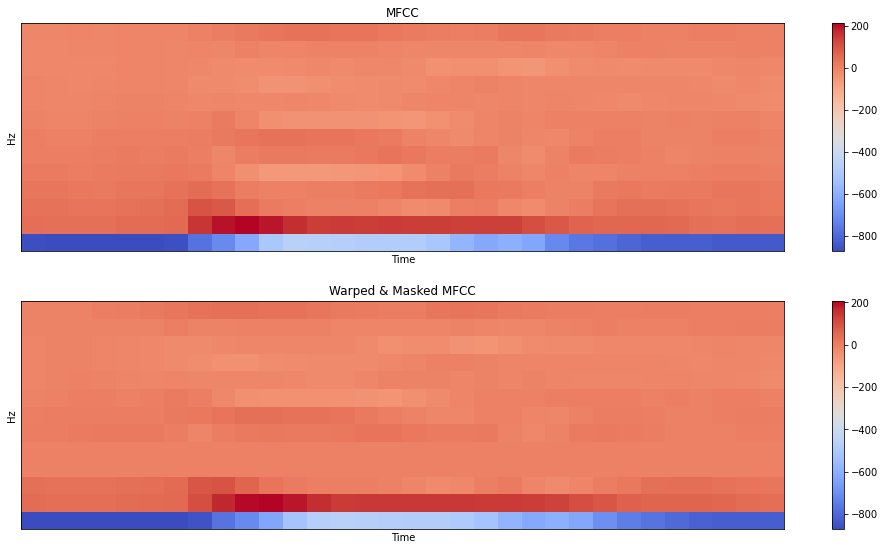

In [ ]:
%cd SpecAugment/
from SpecAugment import spec_augment_pytorch as spau

shape = mfcc.shape
mfcc_reshape = torch.from_numpy(np.reshape(mfcc, (-1, shape[0], shape[1])))
mfcc_warped = spau.spec_augment(mfcc_reshape,
                             time_warping_para=4,
                             time_masking_para=4,
                             frequency_masking_para=5).squeeze().numpy()

fig = plt.figure(figsize=(14,8))
ax1 = plt.subplot(211)
display.specshow(mfcc)
ax1.set_xlabel("Time")
ax1.set_ylabel("Hz")
ax1.set_title("MFCC")
plt.colorbar()

ax2 = plt.subplot(212)
display.specshow(mfcc_warped)
ax2.set_xlabel("Time")
ax2.set_ylabel("Hz")
ax2.set_title("Warped & Masked MFCC")
plt.colorbar()

plt.tight_layout(pad=2.0)
%cd ../

Not sure if you can see but there are a vertical mask at the end of x-axis and a horizontal mask lie merely half-low of y-axis

### Silence removal
Using VAD (Voice Activity Detection). You can use [webrtcvad](https://github.com/wiseman/py-webrtcvad) for this step

### Resampling - Dimensionality Reduction
We can resample out dataset to 8kHz. That means, we will discard some information that should not be important. Also, we will reduce size of the data  
Sometimes, very small difference in performance wins, so we don't want to lost anything. On the other hand, first experiment can be done much faster with smaller training size.

In [ ]:
# Custom FFT
def custom_fft(audio, sample_rate):
  T = 1.0 / sample_rate
  N = audio.shape[0]
  yf = fft(audio)
  xf = np.linspace(0.0, 1.0 / (2.0 * T), N // 2)
  vals = 2.0 / N * np.abs(yf[0:N//2])

  return xf, vals

Hear the same recording with different sample_rate

In [ ]:
id = 9001
waveform, sample_rate, label, *_ = train_set[id]
print(label)
ipd.Audio(waveform.numpy(), rate=sample_rate)

dog


In [ ]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

There is a difference. But not that great

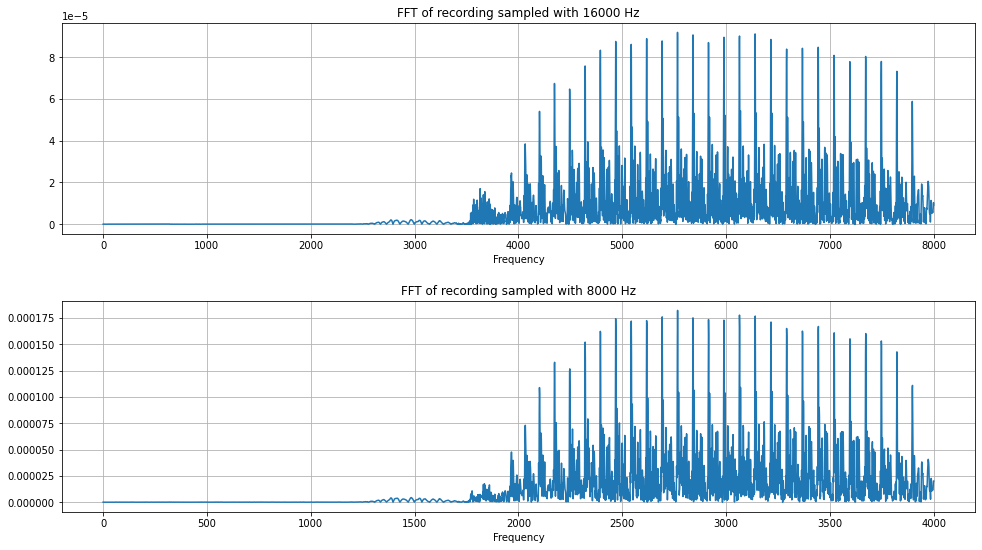

In [ ]:
fig = plt.figure(figsize=(14, 8))

xf, vals = custom_fft(waveform.T.numpy(), sample_rate)
ax1 = plt.subplot(211)
ax1.set_title(f"FFT of recording sampled with {sample_rate} Hz")
ax1.plot(xf, vals)
ax1.set_xlabel('Frequency')
ax1.grid()

xf, vals = custom_fft(transformed.T.numpy(), new_sample_rate)
ax2 = plt.subplot(212)
ax2.set_title(f"FFT of recording sampled with {new_sample_rate} Hz")
ax2.plot(xf, vals)
ax2.set_xlabel('Frequency')
ax2.grid()

plt.tight_layout(pad=2.0)

## Features extraction steps
1. Resampling
2. VAD
3. Padding with 0 to make signals be equal length (if needed)
4. Calculate log spectrogram (or MFCC)
5. Features normalization with *mean* and *std*
5. Stacking of a given number of frames to get temporal information

# Formatting the Data  
Augmentation steps

## Add noise
Add white noise to random audio in batch with the percentage of 30%

In [ ]:
def add_noise(batch, sr=16000):
  noise_thres = 0.3
  for data in batch:
    val = np.random.rand()
    if val < noise_thres:
      data += np.random.normal(0, 0.03, size=sr)
  
  return batch

## Padding
Make all tensor in a batch the same length by padding zeros

In [ ]:
def pad_sequence(batch):
  batch = [item.t() for item in batch]
  batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True)
  
  return batch.permute(0, 2, 1)

## Calculate mel-spectrogram and normalize it
The reason why I use mel-spectrogram instead of MFCC is when applying data to some complicate and strong classifier model like CNN, mel-spectrogram often seems to be effective than MFCC (according to [this](https://stackoverflow.com/a/54326385))  
**Note**: the different between MFCC and mel-spectrogram is that MFCC can be calculated by computing the DCT (Discrete Cosine Transform) on Mel-spectrogram (often be taken log before)  

In [ ]:
def cal_melspec(batch):
  mel_list = []
  for data in batch:
    # Calculate mel-spectrogram
    S = librosa.feature.melspectrogram(data.numpy().squeeze(), sr=sample_rate, n_mels=128)
    # Convert to log scale (dB)
    log_S = librosa.power_to_db(S, ref=np.max)
    # Normalize it
    log_S -= (np.mean(log_S, axis=0) + 1e-8)
    mel_list += [log_S]
  
  return mel_list

## Apply specAugment to mel-spectrogram  
Uncomment lines below if you want to apply specAugment. I choose not to since the audio length of every file is just 1 second. In my opinion (and based on what I have run before), specAugment is not a good choice for short audio clip

In [ ]:
# %cd SpecAugment/
# from SpecAugment import spec_augment_pytorch as spau

# def spec_augment(batch):
#   # reshape mel-spectrogram shape to [batch_size, time, frequency]
#   shape = batch[0].shape
#   batch = [np.reshape(data, (-1, shape[0], shape[1])) for data in batch]
#   batch = [spau.spec_augment(data,
#                              time_warping_para=8,
#                              time_masking_para=8,
#                              frequency_masking_para=30).squeeze().numpy() for data in batch]
#   return batch

## Resize image of mel-spectrogram
Resize spectrogram from 128 x 32 to 32 x 32

In [ ]:
import torchvision.transforms as transforms
from PIL import Image

def resize(batch):
  batch = [Image.fromarray(data) for data in batch]
  resize = transforms.Resize((32, 32))
  batch = [resize(data) for data in batch]

  cvt_to_tensor = transforms.PILToTensor()
  batch = [cvt_to_tensor(data) for data in batch]

  return batch

## Compilation of extracting features steps

In [ ]:
def preprocess(batch):
  batch = pad_sequence(batch)
  # batch = add_noise(batch)
  batch = cal_melspec(batch)
  # batch = spec_augment(batch)
  batch = resize(batch)

  return batch

## Load data for training, validating and testing
We implement a collate function which is used by the PyTorch DataLoader that allows us to iterate over a dataset by batches. Inside it, we apply the resampling, padding, get MFCC features and text encoding

First, we are encoding each word using its index in the list of labels

In [ ]:
def label_to_index(label):
  return torch.tensor(labels.index(label))

def index_to_label(index):
  return labels[index]

word_start = 'yes'
index = label_to_index(word_start)
word_end = index_to_label(index)

print(f'{word_start} -> {index} -> {word_end}')

yes -> 33 -> yes


Now let's make collate_fn function

In [ ]:
def collate_fn(batch):
  tensors, targets = [], []

  for waveform, _, label, *_ in batch:
    tensors += [waveform]
    targets += [label_to_index(label)]

  tensors = preprocess(tensors)
  tensors = torch.stack(tensors)
  targets = torch.stack(targets)

  return tensors, targets


batch_size = 128

if device == "cuda":
  num_workers = 1
  pin_memory = True
else:
  num_workers = 0
  pin_memory = False


train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

# Define the Network
For model, we'll use a simple convolutional neural network (CNN) since we have transformed the audio files into spectrogram images.  
We use `torchsummary` to have summary about our model.

In [ ]:
class CNN(nn.Module):
  def __init__(self, n_input=1, n_output=35, n_channel=32):
    super().__init__()
    self.conv1 = nn.Conv2d(n_input, n_channel, kernel_size=3)
    self.bn1 = nn.BatchNorm2d(n_channel)
    self.conv2 = nn.Conv2d(n_channel, n_channel * 2, kernel_size=3)
    self.bn2 = nn.BatchNorm2d(n_channel * 2)
    self.pool1 = nn.MaxPool2d(2)
    self.do1 = nn.Dropout(0.25)
    self.flat1 = nn.Flatten()
    self.fc1 = nn.Linear(12544, 1024)
    self.do2 = nn.Dropout(0.3)
    self.fc2 = nn.Linear(1024, 128)
    self.do3 = nn.Dropout(0.4)
    self.fc4 = nn.Linear(128, n_output)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(self.bn1(x))
    x = self.conv2(x)
    x = F.relu(self.bn2(x))
    x = self.pool1(x)
    x = self.do1(x)
    x = self.flat1(x)
    x = self.fc1(x)
    x = self.do2(x)
    x = self.fc2(x)
    x = self.do3(x)
    x = self.fc4(x)
    return F.log_softmax(x, dim=1)

from torchsummary import summary

model = CNN(n_input=1, n_output=len(labels)).to(device)
summary(model, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             320
       BatchNorm2d-2           [-1, 32, 30, 30]              64
            Conv2d-3           [-1, 64, 28, 28]          18,496
       BatchNorm2d-4           [-1, 64, 28, 28]             128
         MaxPool2d-5           [-1, 64, 14, 14]               0
           Dropout-6           [-1, 64, 14, 14]               0
           Flatten-7                [-1, 12544]               0
            Linear-8                 [-1, 1024]      12,846,080
           Dropout-9                 [-1, 1024]               0
           Linear-10                  [-1, 128]         131,200
          Dropout-11                  [-1, 128]               0
           Linear-12                   [-1, 35]           4,515
Total params: 13,000,803
Trainable params: 13,000,803
Non-trainable params: 0
-------------------------

# Set up optimizer

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
# Reduce the lr after 20 epochs by a factor of 10
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2)

# Training and Testing the Network
We define training and validating procedure. For each 100 iters, we keep track of current performance of model, which measured by validation loss at that time. If that loss smaller than the smallest one, save model.

In [ ]:
def val(model):
  model.eval()
  val_epoch_loss = 0.0
  for data, target in val_loader:
    data = data.to(device)
    target = target.to(device)

    output = model(data)
    loss = F.nll_loss(output.squeeze(), target)
    val_epoch_loss += loss.item()

  val_losses.append(val_epoch_loss)
  return val_epoch_loss

In [ ]:
path_to_model = '/content/gdrive/MyDrive/models/speechcommands'

def train(model, epoch, log_interval):
  train_epoch_loss = 0.0
  min_val_loss = 100000.0
  for batch_idx, (data, target) in enumerate(train_loader):
    model.train()
    data = data.to(device)
    target = target.to(device)
    
    output = model(data)

    # Negative log-likelihood for a tensor
    loss = F.nll_loss(output.squeeze(), target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # print training stats
    if batch_idx % log_interval == 0:
      val_loss = val(model)
      print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tValidation Loss: {val_loss:.6f}")
      if val_loss < min_val_loss:
        print(f"Validation Loss Decreased from {min_val_loss:.6f} ---> {val_loss:.6f}. Saving model...")
        torch.save(model.state_dict(), path_to_model + '/best_model.pth')
        min_val_loss = val_loss
        print("Saved!")

    # Update progress bar
    pbar.update(pbar_update)
    # Sum loss
    train_epoch_loss += loss.item()
    # Record loss
    train_losses.append(loss.item())

  # Save model at last of epoch
  torch.save(model.state_dict(), path_to_model + f'/saved_model_e{epoch}.pth')

In [ ]:
log_interval = 100
n_epoch = 2

pbar_update = 1 / (len(train_loader) + len(test_loader))
train_losses = []
val_losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
  for epoch in range(1, n_epoch + 1):
    train(model, epoch, log_interval)
    scheduler.step()
  print("===== DONE!! =====")

  0%|          | 0/2 [00:00<?, ?it/s]

Train Epoch: 1 [0/105829 (0%)]	Validation Loss: 25320.457672
Validation Loss Decreased from 100000.000000 ---> 25320.457672. Saving model...
Saved!
Train Epoch: 1 [12800/105829 (12%)]	Validation Loss: 226.164000
Validation Loss Decreased from 25320.457672 ---> 226.164000. Saving model...
Saved!
Train Epoch: 1 [25600/105829 (24%)]	Validation Loss: 181.338969
Validation Loss Decreased from 226.164000 ---> 181.338969. Saving model...
Saved!
Train Epoch: 1 [38400/105829 (36%)]	Validation Loss: 169.085427
Validation Loss Decreased from 181.338969 ---> 169.085427. Saving model...
Saved!
Train Epoch: 1 [51200/105829 (48%)]	Validation Loss: 160.797445
Validation Loss Decreased from 169.085427 ---> 160.797445. Saving model...
Saved!
Train Epoch: 1 [64000/105829 (60%)]	Validation Loss: 151.367657
Validation Loss Decreased from 160.797445 ---> 151.367657. Saving model...
Saved!
Train Epoch: 1 [76800/105829 (73%)]	Validation Loss: 135.370226
Validation Loss Decreased from 151.367657 ---> 135.37022

Text(0.5, 1.0, 'Validation loss')

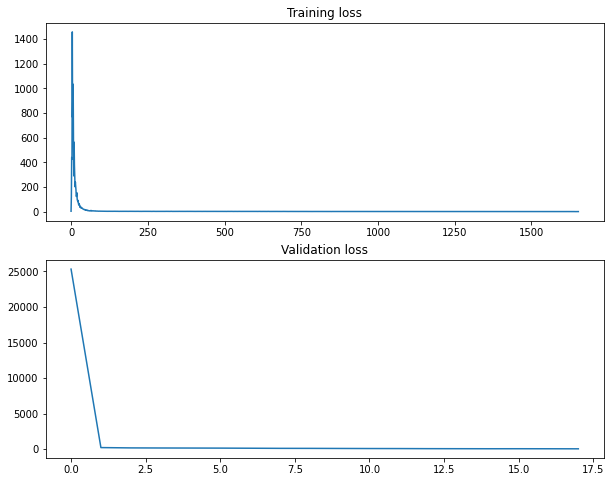

In [ ]:
# Let's plot the training loss versus the number of iteration.
plt.figure(figsize=(10, 8))
plt.subplot(211)
plt.plot(train_losses)
plt.title("Training loss")
plt.subplot(212)
plt.plot(val_losses)
plt.title("Validation loss")

Now let's test on the entire test set and plot a confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

def number_of_correct(pred, target):
  # count number of correct predictions
  return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
  # find most likely label index for each element in the batch
  return tensor.argmax(dim=-1)


def get_confusion_matrix(target, pred):
  """
  Plot confusion matrix
  """
  confusion_mtx = confusion_matrix(target.cpu(), pred.cpu())
  plt.figure(figsize=(20, 17))
  sns.heatmap(confusion_mtx,
              xticklabels=labels,
              yticklabels=labels,
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()


def test(model):
  model.eval()
  y_pred = torch.tensor([], device='cuda')
  y_true = torch.tensor([], device='cuda')
  correct = 0
  for data, target in tqdm(test_loader):

    data = data.to(device)
    target = target.to(device)
    
    output = model(data)

    pred = get_likely_index(output)
    y_pred = torch.cat((y_pred, pred.squeeze()), dim=0)
    y_true = torch.cat((y_true, target), dim=0)
    correct += number_of_correct(pred, target)

    # update progress bar
    pbar.update(pbar_update)

  get_confusion_matrix(y_true, y_pred)
  print(f"\nTest:\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

  0%|          | 0/86 [00:00<?, ?it/s]

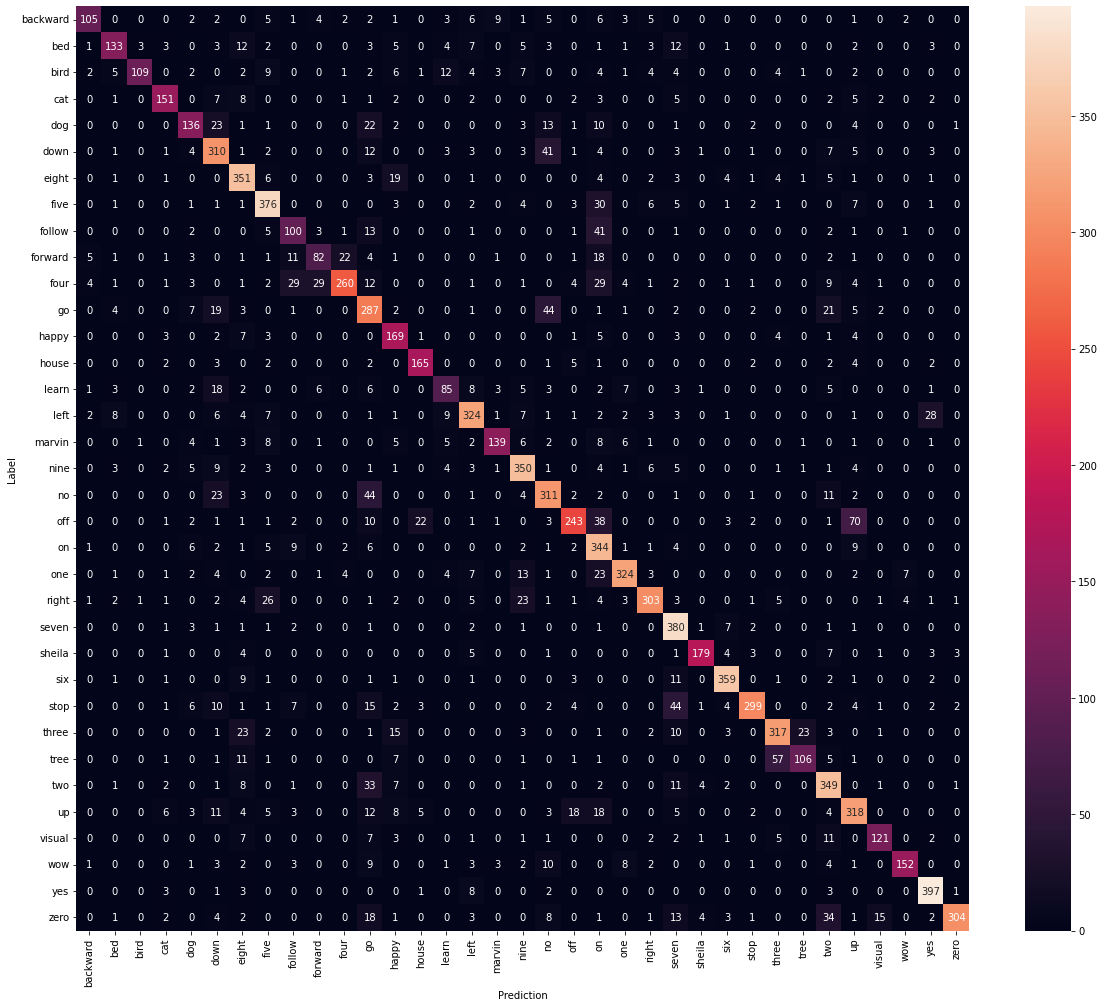


Test:	Accuracy: 8438/11005 (77%)



In [ ]:
# Test
# test_model = torch.load(path_to_model + '/best_model.pth')
# test_model.load_state_dict(test_model)

test(model)